In [1]:
import data_base as db
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter
from datetime import datetime
import time
from scipy import stats

In [2]:
clients = pd.read_csv('./data/clients.csv', sep = ';')
products = pd.read_csv('./data/products.csv', sep = ';')
#bills = pd.read_csv('./data/bills.csv', sep = ';')

In [3]:
print('Женщин :', clients.groupby('sex').size()[0]/clients.shape[0]*100)
print('Мужчин :', clients.groupby('sex').size()[1]/clients.shape[0]*100)

Женщин : 53.48711683781468
Мужчин : 46.51288316218532


### Распределение по возрасту всех зарегистрированных в системе клиентов (муж/жен)

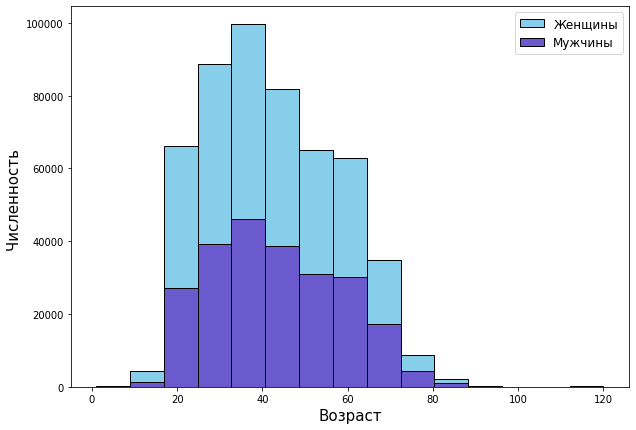

In [8]:

df1 = clients.loc[clients['age'] >0 ]['age']
#clients.loc[clients['age'] >0 ].loc[clients['sex'] =='жен' ]['age'][1:] 
df2 = clients.loc[clients['age'] >0 ].loc[clients['sex'] =='муж' ]['age'] 

fig, ax = plt.subplots()

ax.hist( df1, label = 'Женщины',bins = 15, color = 'skyblue', edgecolor='black')
ax.hist( df2, label = 'Мужчины',bins = 15, color = 'slateblue', edgecolor='black')


ax.legend(fontsize=12)

plt.ylabel('Численность ', fontsize=15)
plt.xlabel('Возраст', fontsize=15)
#plt.title("Распределение по возрасту всех\n зарегистрированных в системе клиентов", fontsize=22)


fig.set_figheight(7)
fig.set_figwidth(10)


plt.show()

In [5]:
connection, cursor = db.connect_db()
cursor.execute('''
SELECT 

    bills.check_id,
    sum(bills.before_discount_amt),
    clients.sex,
    clients.age

FROM bills LEFT JOIN (SELECT
                            clients.customer_id,
                            clients.sex,
                            clients.age
                    FROM clients) clients
                    ON (clients.customer_id = bills.customer_id)
WHERE clients.age BETWEEN 20 AND 80

GROUP BY 1,3,4
''')
result = cursor.fetchall()
db.close_connection(connection, cursor)
clients_bills = pd.DataFrame(result, columns = [
                                'check_id',
                                'amt',
                               'sex',
                               'age'])


Database opened successfully


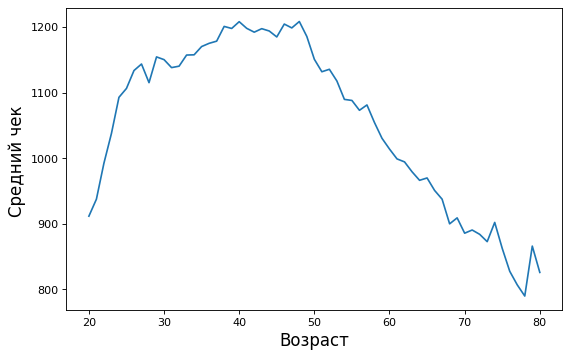

In [6]:
df1 = clients_bills.loc[clients_bills['age'] >0 ].groupby('age').mean().reset_index()

plt.figure(figsize=(8,5), dpi= 80)

plt.plot(df1['age'], df1['amt'], label = 'ЧЕКИ')

plt.ylabel('Средний чек ', fontsize=15)
plt.xlabel('Возраст', fontsize=15)
#plt.title
plt.show()

### По товарным направлениям

In [7]:
connection, cursor = db.connect_db()
cursor.execute('''
SELECT
    t1.product_direction_name,
    t1.customer_id,
    t1.before_discount_amt,
    t1.check_id,
    clients.sex,
    clients.age
FROM
    (SELECT 
        products.product_direction_name,
        bills.customer_id,
        bills.product_category,
        bills.product_group,
        bills.subgroup,
        bills.check_id,
        bills.before_discount_amt

    FROM bills LEFT JOIN (SELECT
                            products.category_name,
                            products.group_name,
                            products.subgroup_name,
                            products.product_direction_name
                        FROM
                            products) products
                        ON (products.category_name = bills.product_category
                        AND products.group_name = bills.product_group
                        AND products.subgroup_name = bills.subgroup)
    ) t1 LEFT JOIN (SELECT
                        clients.customer_id,
                        clients.sex,
                        clients.age
                    FROM clients) clients
                    ON (clients.customer_id = t1.customer_id )
WHERE clients.age BETWEEN 20 AND 80
''')
result = cursor.fetchall()
db.close_connection(connection, cursor)
product_direction = pd.DataFrame(result, columns = ['product_direction_name',
                                                    'customer_id',
                                                    'before_discount_amt',
                                                    'check_id',
                                                    'sex',
                                                    'age'])

Database opened successfully


In [8]:
product_direction

,product_direction_name,customer_id,before_discount_amt,check_id,sex,age
0,КРАСОТА,1ec0641d-5947-4b94-b495-79279dd900d6-ws,2825.0,20200228209002037300032,жен,43.0
1,ЧИСТОТА,1ec0641d-5947-4b94-b495-79279dd900d6-ws,355.0,20200228209002037300032,жен,43.0
2,КРАСОТА,27809dfd-e37a-4799-ac7b-522a55374e4e-ws,200.0,20200228215602074300045,муж,31.0
3,КРАСОТА,238697f8-5b72-4a0c-8a71-25858bb7cb4c-ws,273.0,20200228215602074300084,муж,29.0
4,ЧИСТОТА,65092f73-f326-4c91-a643-ae3152e0f07b-ws,169.0,20200228215701073300065,муж,37.0
...,...,...,...,...,...,...
8559191,КРАСОТА,3f339801-fe27-4548-ac95-8a2c7159bca9-ws,132.0,20200228204601074700013,жен,39.0
8559192,КРАСОТА,ae28dc9f-65b3-4964-b7bf-53fa8c3d8d0d-ws,7.9,20200228204202039900121,жен,39.0
8559193,ЧИСТОТА,e14b6f91-77a5-450a-9847-b6725f91fddd-ws,120.0,20200228204301074600007,жен,45.0
8559194,ДЕКОР,ada9b05b-9fbf-4ea9-985e-c361cdd27c2a-ws,992.0,20200228204301074600057,муж,22.0


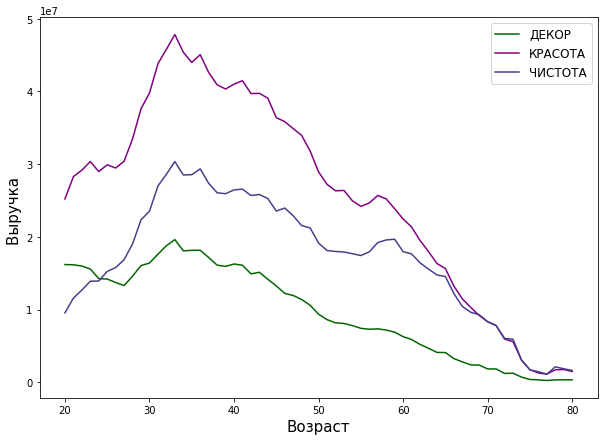

In [13]:
df3 = product_direction.loc[product_direction['product_direction_name'] == 'ДЕКОР'].groupby('age').sum()
df4 = product_direction.loc[product_direction['product_direction_name'] == 'КРАСОТА'].groupby('age').sum()
df5 = product_direction.loc[product_direction['product_direction_name'] == 'ЧИСТОТА'].groupby('age').sum()

fig, ax = plt.subplots()

ax.plot( df3, label = 'ДЕКОР', color = 'darkgreen')
ax.plot( df4, label = 'КРАСОТА', color = 'purple')
ax.plot( df5, label = 'ЧИСТОТА', color = 'darkslateblue')




ax.legend(fontsize=12)

plt.ylabel('Выручка ', fontsize=15)
plt.xlabel('Возраст', fontsize=15)
#plt.title("Распределение по возрасту всех\n зарегистрированных в системе клиентов", fontsize=22)


fig.set_figheight(7)
fig.set_figwidth(10)


plt.show()

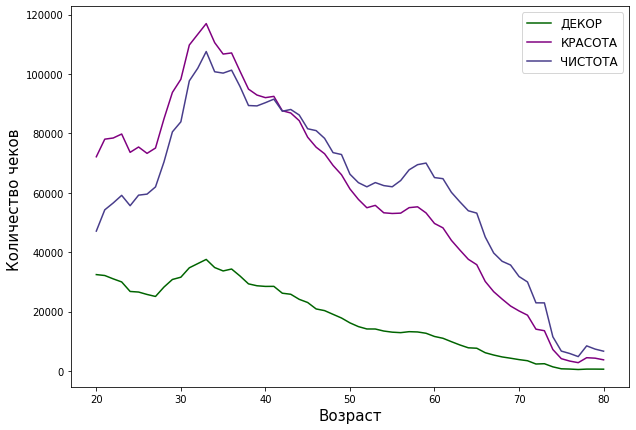

In [52]:
df3 = product_direction.loc[product_direction['product_direction_name'] == 'ДЕКОР'].groupby('age').size()
df4 = product_direction.loc[product_direction['product_direction_name'] == 'КРАСОТА'].groupby('age').size()
df5 = product_direction.loc[product_direction['product_direction_name'] == 'ЧИСТОТА'].groupby('age').size()

fig, ax = plt.subplots()

ax.plot( df3, label = 'ДЕКОР', color = 'darkgreen')
ax.plot( df4, label = 'КРАСОТА', color = 'purple')
ax.plot( df5, label = 'ЧИСТОТА', color = 'darkslateblue')




ax.legend(fontsize=12)

plt.ylabel('Количество чеков ', fontsize=15)
plt.xlabel('Возраст', fontsize=15)
#plt.title("Распределение по возрасту всех\n зарегистрированных в системе клиентов", fontsize=22)


fig.set_figheight(7)
fig.set_figwidth(10)


plt.show()

In [172]:
clients['children_count'].isna().sum() / clients.shape[0]

0.9742509633078629